# CKP8087 - Estrutura de Dados
<img  src="https://img.shields.io/badge/UFC_CKP8087-VAUX GOMES-000000?style=for-the-badge&logo=" /> <img src="https://img.shields.io/badge/Jupyter-000000?style=for-the-badge&logo=jupyter&logoColor=white" /> <img src="https://img.shields.io/badge/Python-000000?style=for-the-badge&logo=python&logoColor=white" /> 

In [21]:
!pip install numpy pandas
!pip install networkx
!pip install matplotlib
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 27.8 MB/s eta 0:00:00m eta 0:00:010:00:01


### Bibliotecas principais

In [2]:
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

### Loading

In [3]:
df = pd.read_csv('./files/dados.csv')
df.rename(columns={'score_sentiment': 'sentiment', 'score_misinformation': 'misinformation'}, inplace=True)

# df['bold'] = df.text.str.match(r'\*\*(.*?)\*\*').astype(bool)
# df['italic'] = df.text.str.match(r'_\*(.*?)\*_').astype(bool)

# Flag de viral
counts = df['text'].value_counts()
df['isviral'] = df['text'].isin(counts[counts > 1].index)

# Flaf de misinformation
df['ismisinformation'] = df.misinformation >= 0.7

df.shape

(186316, 7)

In [4]:
df.head(5)

,member,group,text,sentiment,misinformation,isviral,ismisinformation
0,3a8e41b9e1da548ef0acd0a57b398da4,e110071613239754d38878f7e046e95b,Jovem vai a sessão parlamentar na câmara dos v...,0.6371,0.001867,True,False
1,3a8e41b9e1da548ef0acd0a57b398da4,7ee4235534ec624ebd61373b87ad8c20,Jovem vai a sessão parlamentar na câmara dos v...,0.6371,0.001867,True,False
2,3a8e41b9e1da548ef0acd0a57b398da4,ee85f63c945ffa50ba8bb57acf2c1bf9,Jovem vai a sessão parlamentar na câmara dos v...,0.6371,0.001867,True,False
3,ef496106907ece8b169c6219e5470b2c,4450dfcd32cb7582037943ca7c682e2d,*Dilma merece pedido de desculpas por impeachm...,0.4019,NaN,True,False
4,4ea1b3ee637da811b7d2d0df32db21f9,3b75f897e41fca595457f2ad9e101260,*Dilma merece pedido de desculpas por impeachm...,0.4019,NaN,True,False


### Construindo a estrutura de gráfico

In [5]:
geral  = df[['member', 'group', 'isviral', 'ismisinformation']]
viral = geral[geral.isviral]
misin = geral[geral.ismisinformation]

In [6]:
#
def build(df):
    graph = {}
    stats = {
        'geral': df.shape[0],
        'viral': df[df.isviral].shape[0],
        'viral_p': df[df.isviral].shape[0]/df.shape[0],
        'misin': df[df.ismisinformation].shape[0],
        'misin_p': df[df.ismisinformation].shape[0]/df.shape[0],
        'both': df[df.isviral & df.ismisinformation].shape[0],
        'both_p': df[df.isviral & df.ismisinformation].shape[0]/df.shape[0],
    
        'members': df.member.unique().size,
        'grups': df.group.unique().size
    }
    
    for group in df.group.unique(): 
        members = df[df.group == group].member.value_counts()
        
        for s, v in members.items():
            for r in members.keys():
                if s == r: 
                    continue
    
                graph[s] = graph.get(s, {})
                graph[s][r] = graph[s].get(r, 0) + v

    return graph, stats

In [7]:
%time graph_geral, stats_geral = build(geral)
%time graph_viral, stats_viral = build(viral)
%time graph_misin, stats_misin = build(misin)

CPU times: user 2.55 s, sys: 19.3 ms, total: 2.57 s
Wall time: 2.56 s
CPU times: user 1.41 s, sys: 12.1 ms, total: 1.42 s
Wall time: 1.42 s
CPU times: user 155 ms, sys: 959 μs, total: 156 ms
Wall time: 156 ms


#### Tabela resumo

In [8]:
stats_geral['type'] = 'geral'
stats_viral['type'] = 'viral'
stats_misin['type'] = 'misin'

pd.DataFrame.from_dict([stats_geral, stats_viral, stats_misin])

,geral,viral,viral_p,misin,misin_p,both,both_p,members,grups,type
0,186316,110091,0.590883,8749,0.046958,5181,0.027808,6165,237,geral
1,110091,110091,1.000000,5181,0.047061,5181,0.047061,3487,225,viral
2,8749,5181,0.592182,8749,1.000000,5181,0.592182,1647,175,misin


# Parte I - NetworkX

https://networkx.org/

### Funções de montagem e métricas não presentes na biblioteca

In [9]:
# Função de montagem do grafo
def networkX(graph, color='black'):
    G = nx.Graph() # nx.DiGraph()
    
    for s in graph:
        for r in graph[s]:
            G.add_edge(s, r, weight=graph[s][r], color=color)

    return G

# Cálculo da força
def force(G):
  forces = {}

  for source, target, stats in list(G.edges(data=True)):
    forces[source] = forces.get(source, 0) + stats['weight']

  return forces

# Come to the force
nx.force = force

# Giant coefficient
def giant_coefficient(G):
    giant = G.subgraph(max(nx.connected_components(G), key=len))
    return len(giant.nodes)/len(G.nodes)

#
nx.giant_coefficient = giant_coefficient


# Montando os grafos
gg = networkX(graph_geral, color='red')
gv = networkX(graph_viral, color='blue')
gm = networkX(graph_misin, color='green')

### Métricas dos Nós

| Métrica | Suporte |
| -- | -- |
|Degree centrality| `nativo` |
|Clustering coefficient| `nativo` |
|Closeness centrality| `nativo` |
|Betweennes centrality| `nativo` |
|Force| `desenvolvido` |

In [10]:
# Geral
g_centrality =  pd.DataFrame.from_dict([nx.degree_centrality(gg)]).T.rename(columns={0: 'centrality_g'})
g_force =       pd.DataFrame.from_dict([nx.force(gg)]).T.rename(columns={0: 'force_g'})
g_clustering =  pd.DataFrame.from_dict([nx.clustering(gg)]).T.rename(columns={0: 'clustering_g'})
g_closeness =   pd.DataFrame.from_dict([nx.closeness_centrality(gg)]).T.rename(columns={0: 'closeness_g'})
g_betweenness = pd.DataFrame.from_dict([nx.betweenness_centrality(gg)]).T.rename(columns={0: 'betweenness_g'})
#
gg_ = pd.concat([g_centrality, g_force, g_clustering, g_closeness, g_betweenness], axis=1)

In [11]:
# Viral
v_centrality =  pd.DataFrame.from_dict([nx.degree_centrality(gv)]).T.rename(columns={0: 'centrality_v'})
v_force =       pd.DataFrame.from_dict([nx.force(gv)]).T.rename(columns={0: 'force_v'})
v_clustering =  pd.DataFrame.from_dict([nx.clustering(gv)]).T.rename(columns={0: 'clustering_v'})
v_closeness =   pd.DataFrame.from_dict([nx.closeness_centrality(gv)]).T.rename(columns={0: 'closeness_v'})
v_betweenness = pd.DataFrame.from_dict([nx.betweenness_centrality(gv)]).T.rename(columns={0: 'betweenness_v'})
#
gv_ = pd.concat([v_centrality, v_force, v_clustering, v_closeness, v_betweenness], axis=1)

In [12]:

# Misinformation
m_centrality =  pd.DataFrame.from_dict([nx.degree_centrality(gm)]).T.rename(columns={0: 'centrality_m'})
m_force =       pd.DataFrame.from_dict([nx.force(gm)]).T.rename(columns={0: 'force_m'})
m_clustering =  pd.DataFrame.from_dict([nx.clustering(gm)]).T.rename(columns={0: 'clustering_m'})
m_closeness =   pd.DataFrame.from_dict([nx.closeness_centrality(gm)]).T.rename(columns={0: 'closeness_m'})
m_betweenness = pd.DataFrame.from_dict([nx.betweenness_centrality(gm)]).T.rename(columns={0: 'betweenness_m'})
#
gm_ = pd.concat([m_centrality, m_force, m_clustering, m_closeness, m_betweenness], axis=1)

In [13]:
# Exibição
pd.merge(
  pd.merge(gg_, gv_, how='left', left_index=True, right_index=True), 
  gm_, how='left', left_index=True, right_index=True).head(5)

,centrality_g,force_g,clustering_g,closeness_g,betweenness_g,centrality_v,force_v,clustering_v,closeness_v,betweenness_v,centrality_m,force_m,clustering_m,closeness_m,betweenness_m
3a8e41b9e1da548ef0acd0a57b398da4,0.000488,51.0,1.000000,0.000488,0.000000,0.000864,51.0,1.000000,0.000864,0.000000,NaN,NaN,NaN,NaN,NaN
df5ce4fa38568a7c3ddb881ec2bcf327,0.000488,8.0,1.000000,0.000488,0.000000,0.000864,8.0,1.000000,0.000864,0.000000,NaN,NaN,NaN,NaN,NaN
42991ff9fbd534363741ee7531beb189,0.000488,4.0,1.000000,0.000488,0.000000,0.000864,4.0,1.000000,0.000864,0.000000,NaN,NaN,NaN,NaN,NaN
88cc4f89f35493b30b96a60da7938e1c,0.000488,NaN,1.000000,0.000488,0.000000,0.000864,NaN,1.000000,0.000864,0.000000,NaN,NaN,NaN,NaN,NaN
ef496106907ece8b169c6219e5470b2c,0.001789,1866.0,0.672727,0.258109,0.000547,0.002305,1828.0,0.571429,0.227686,0.000854,NaN,NaN,NaN,NaN,NaN


#### Top 5

In [14]:
def top(df, t=5): 
  print(f'TOP {t}')
  
  for col in df.columns:
    print(col.split('_')[0].title())
    print('-')
    
    for i, el in enumerate(df[col].sort_values(ascending=False)[:t].items()):
      member, score = el
      print(f'{i+1}: {member} = {score:.4f}')
    
    print()
    
top(gg_)
top(gv_)
top(gm_)


TOP 5
Centrality
-
1: 5edf52cacaced85501ff2c59d316d696 = 0.1895
2: 3b7dfe232868b409b22d6717df3e3851 = 0.1757
3: db163c719d8fe5031fbd48783d6554b1 = 0.1672
4: b348ff97155fcbcfd7036153c89ddb68 = 0.1636
5: e6022a7e3955297a7a4c3028f0f2a99d = 0.1636

Force
-
1: 3545bf472c131392f18ed78a07f7552e = 51180.0000
2: 3b7dfe232868b409b22d6717df3e3851 = 25017.0000
3: c5fff63b6151f93e1ce86d12f8acbee1 = 22782.0000
4: a7cd207cf04eca0e47a157071df25118 = 22177.0000
5: 8a6a2f1791314cff39b7da988cb62069 = 21287.0000

Clustering
-
1: f803a0bac47c89426bcb1f1d4e666251 = 1.0000
2: 3a8e41b9e1da548ef0acd0a57b398da4 = 1.0000
3: df5ce4fa38568a7c3ddb881ec2bcf327 = 1.0000
4: 6d98359384201edc7b7dcf9b37a5b9d2 = 1.0000
5: 131f22bd5a2c9afa8d8f3f3d650d1cb1 = 1.0000

Closeness
-
1: 83d61b8555f77383e6a699dafe5cca75 = 0.3840
2: 5edf52cacaced85501ff2c59d316d696 = 0.3837
3: 6a8c33817fef00b8eeabe6ee5f05473d = 0.3809
4: db163c719d8fe5031fbd48783d6554b1 = 0.3806
5: e49bad7e3735041101fe3b2217a8c89a = 0.3773

Betweenness
-
1: b13078d

### Métricas de Grafos

| Métrica | Suporte |
| -- | -- |
| Giant Coefficient | `desenvolvido` |
| Density | `nativo` |
| Diameter | `nativo` |


In [15]:
g_giant_coefficient = nx.giant_coefficient(gg)
g_density = nx.density(gg)
try: g_diameter = nx.diameter(gg)
except: g_diameter = nx.diameter(gg.subgraph(max(nx.connected_components(gg), key=len)))

print('# Geral')
print(f'Giant Coefficient: {g_giant_coefficient:.4f}')
print(f'Density: {g_density:.4f}')
print(f'Diameter: {g_diameter:.4f}')

# Geral
Giant Coefficient: 0.8416
Density: 0.0257
Diameter: 10.0000


In [16]:
v_giant_coefficient = nx.giant_coefficient(gv)
v_density = nx.density(gv)
try: v_diameter = nx.diameter(gv)
except: v_diameter = nx.diameter(gv.subgraph(max(nx.connected_components(gv), key=len)))

print('# Viral')
print(f'Giant Coefficient: {v_giant_coefficient:.4f}')
print(f'Density: {v_density:.4f}')
print(f'Diameter: {v_diameter:.4f}')

# Viral
Giant Coefficient: 0.7414
Density: 0.0246
Diameter: 9.0000


In [17]:
m_giant_coefficient = nx.giant_coefficient(gm)
m_density = nx.density(gm)
try: m_diameter = nx.diameter(gm)
except: m_diameter = nx.diameter(gm.subgraph(max(nx.connected_components(gm), key=len)))

print('# Misinformation')
print(f'Giant Coefficient: {m_giant_coefficient:.4f}')
print(f'Density: {m_density:.4f}')
print(f'Diameter: {m_diameter:.4f}')

# Misinformation
Giant Coefficient: 0.6342
Density: 0.0279
Diameter: 10.0000


### Análise visual

CPU times: user 2min 13s, sys: 402 ms, total: 2min 14s
Wall time: 1min 35s


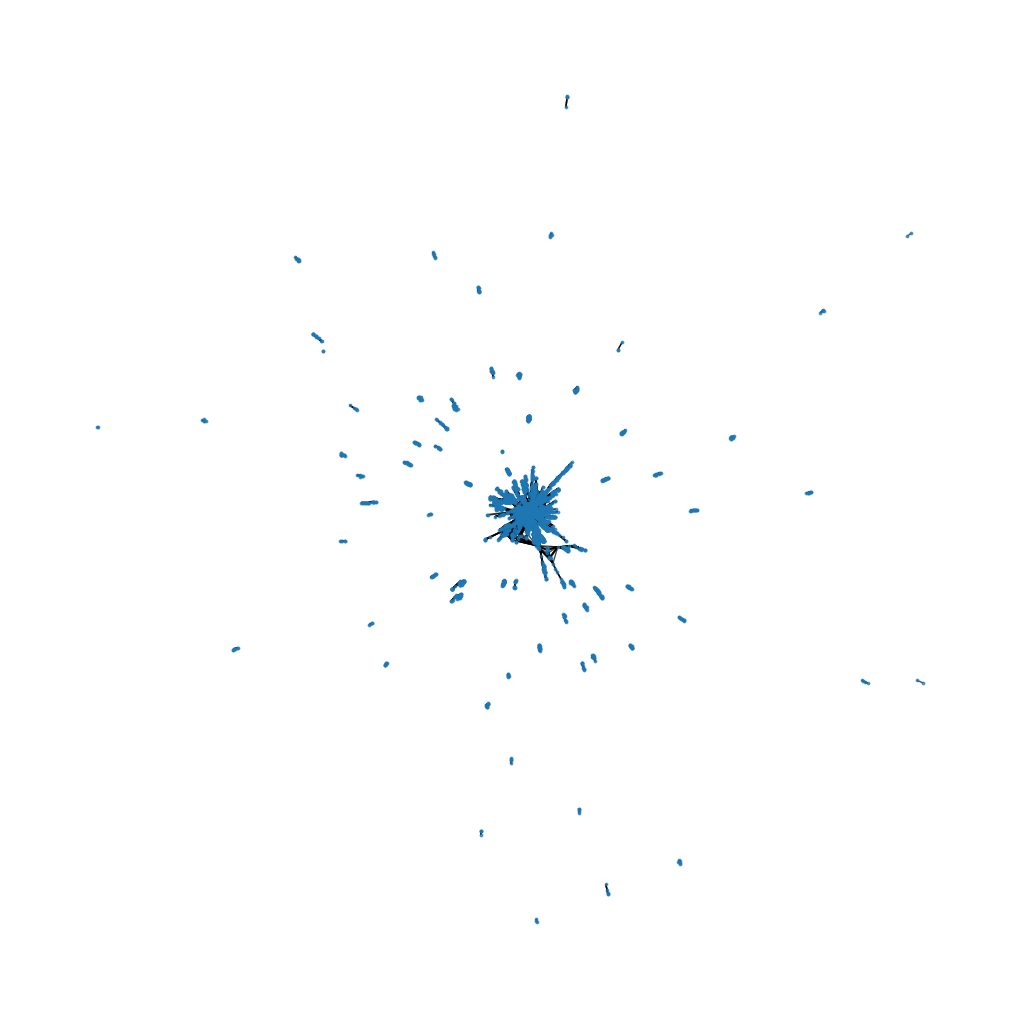

In [23]:
plt.figure(figsize=(10, 10))
%time nx.draw(gg, alpha=0.7, node_size=3, with_labels=False, pos=nx.spring_layout(gg))

CPU times: user 9.47 s, sys: 34 ms, total: 9.5 s
Wall time: 9.5 s


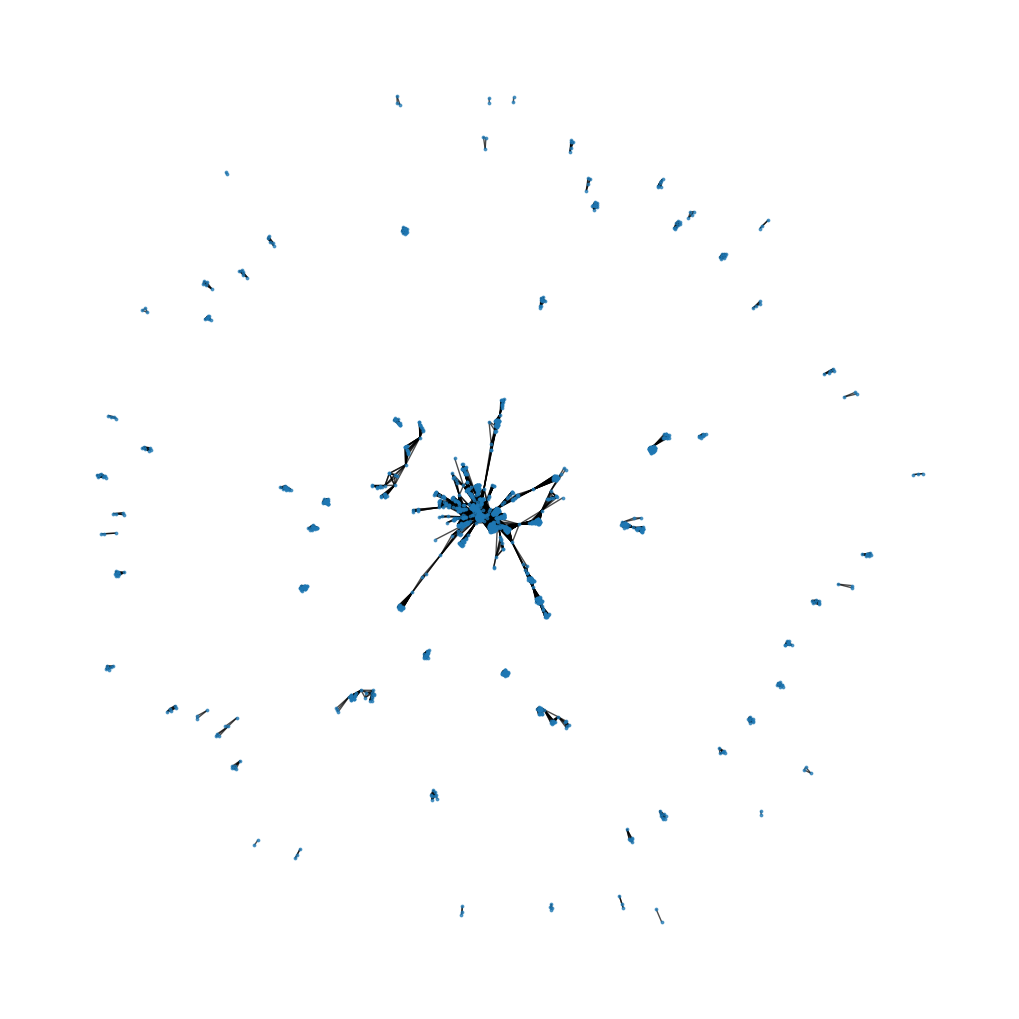

In [24]:
plt.figure(figsize=(10, 10))
%time nx.draw(gm, alpha=0.7, node_size=3, with_labels=False, pos=nx.spring_layout(gm))

CPU times: user 34.4 s, sys: 112 ms, total: 34.5 s
Wall time: 33.7 s


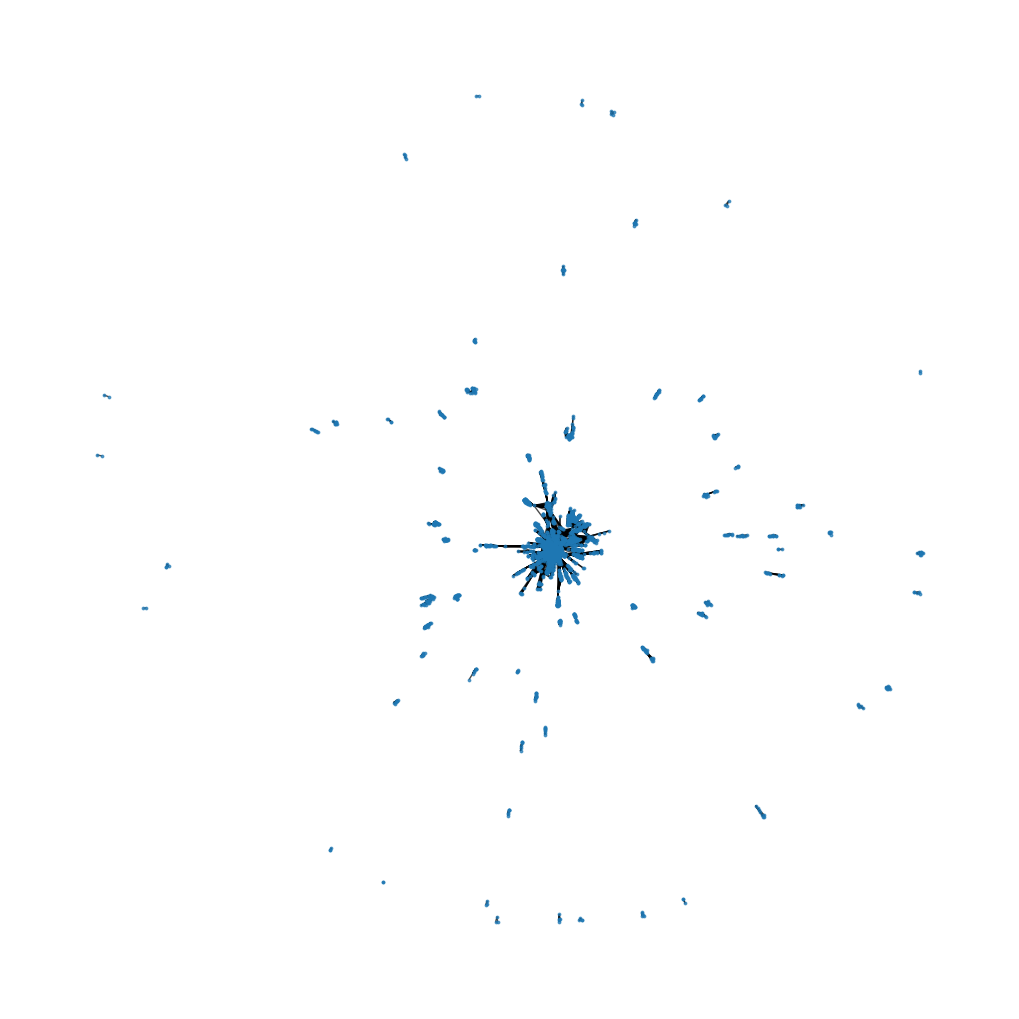

In [22]:
plt.figure(figsize=(10, 10))
%time nx.draw(gv, alpha=0.7, node_size=3, with_labels=False, pos=nx.spring_layout(gv))

CPU times: user 897 ms, sys: 53 ms, total: 950 ms
Wall time: 949 ms


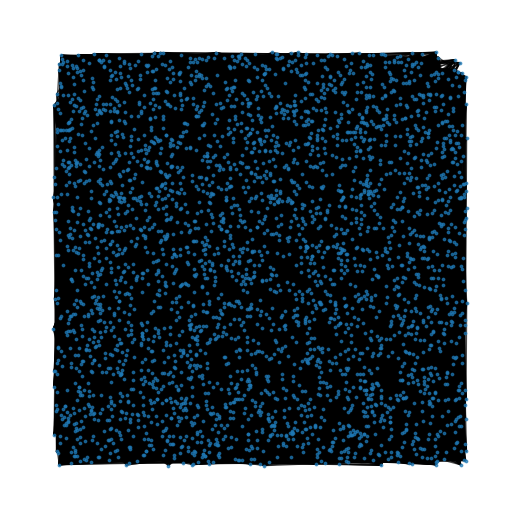

In [26]:
plt.figure(figsize=(5, 5))
%time nx.draw(gv, alpha=0.7, node_size=3, with_labels=False, pos=nx.random_layout(gv))

In [25]:
nx.write_graphml(gg, './files/gg.graphml') 
nx.write_graphml(gv, './files/gv.graphml') 
nx.write_graphml(gm, './files/gm.graphml') 